In [8]:
## This Noteboook generates Figure 3 in Ori et al., 2020 
## R Scripts to employ hierarchical clustering on genes with significant association to real time per stage

## Following Table is produced:
#  data/Suppl_Table_7_DE_FE_clustering.xlsx

library(limma)
library(Matrix)
library(splines)
library(ggplot2)
library(pheatmap)
library(reshape2)
library(rhdf5)
library(tidyr)
library(gridExtra)

### Read in annData object

In [18]:
setwd("/20200806_Drukker_IPSlungProgenitors_meshal.ansari/")
file <- H5Fopen("IPS_lung_differentiation.h5ad", flags = "H5F_ACC_RDONLY")

contents <- rhdf5::h5dump(file)
rhdf5::H5Fclose(file)

cell_meta <- contents$obs
gene_meta <- contents$var
cords = contents$obsm$X_umap

meta <- data.frame(day = cell_meta[["day"]], n_counts = cell_meta[["n_counts"]], 
                   GFP_NKX21 = cell_meta[["GFP_NKX"]], dpt = cell_meta[["dpt"]],
                   umap1 = cords[1,], umap2 = cords[2,], row.names = cell_meta[["cell_barcode"]])
print(head(meta))

## scaled data slot for average expression heatmap
scaled_data <- data.matrix(contents$X)
rownames(scaled_data) = as.vector(gene_meta[["index"]])
colnames(scaled_data) = as.vector(cell_meta[["cell_barcode"]])

## normalized, log transformed data slot
data <- Matrix::sparseMatrix(
            i = contents$raw$X$indices + 1,
            p = contents$raw$X$indptr,
            x = as.vector(contents$raw$X$data),
            dims = c(length(gene_meta[["index"]]), length(cell_meta[["cell_barcode"]])),
            dimnames = list(as.vector(gene_meta[["index"]]), as.vector(cell_meta[["cell_barcode"]])))

print(dim(data))

                     day n_counts GFP_NKX21        dpt     umap1    umap2
muc6865_CTCGATGGCGCA   0     4953         0 0.18503945 -6.080726 3.744942
muc6865_TTTACGGCCATT   0     4932         0 0.20621461 -6.606641 3.732040
muc6865_TCACTATCCGTA   0     4887         0 0.04926153 -3.506208 3.871340
muc6865_AGATGACTTAGA   0     4881         0 0.18080762 -5.569048 4.474619
muc6865_ATGAAGGCGTAA   0     4857         0 0.19337354 -5.550567 4.502900
muc6865_GCCATTAAATTA   0     4739         0 0.09692066 -4.009118 3.751017
[1] 26936 10667


In [4]:
fit_splines <- function(data, meta, no.ribo = T, kn = c(1, 6, 10, 14)){
  nUMI <- as.numeric(meta$n_counts)
  
  ## Exclude ribosomal genes
  ribo.genes <- grep(pattern = "^RP", x = rownames(data), value = TRUE)
  data <- data[!rownames(data) %in% ribo.genes,]
  
  dfAnnot <- data.frame(
    cell = colnames(data), pseudotime = meta$day,  
    nUMI = nUMI, stringsAsFactors = FALSE, row.names = colnames(data)
  )
  
  ## Spline Fit
  splines <- try(ns(dfAnnot$pseudotime, knots = kn))
  dfAnnot$pt_spline <- splines
  design <- model.matrix(~ nUMI + pt_spline, data = dfAnnot)
  
  data <- data[apply(data, 1, var) > 0, ]
  fit <- lmFit(data, design)
  fit <- eBayes(fit)
  dfRes <- topTable(fit, adjust = "BH", number = Inf, sort.by = "none", coef = 3:ncol(design))
  
  ## additionally output mean expresssion of the respective time points
  means <- t(apply(data, 1, function(x) unlist(lapply(split(1:ncol(data), dfAnnot$pseudotime),
                                                      function(y) mean(x[y])))))
  res <- data.frame(dfRes, means)
  res <- res[order(res$P.Value, decreasing = F),]
  return(res)
}
                                                      
cluster_temporal_genes <- function(data, meta){
    
    means <- aggregate(data.matrix(t(data)), list(meta$day), mean)
    rownames(means) <- means$Group.1
    means$Group.1 <- NULL
    means <- as.data.frame(t(means))

    ## Use these average expressions (from scaled data slot) for Hierarchical Clustering
    h.cluster <- means %>% dist(., method = "euclidean") %>% hclust(., method = "ward.D")
    #ggdendrogram(h.cluster)
    means$cluster.k10 <- cutree(h.cluster, k = 10)
    means$cluster.k20 <- cutree(h.cluster, k = 20)
    return(means)
}

### Definite Endoderm - Spline Fit using time point of sampling

In [6]:
## Select only those cells from first stage (day 0 - 6) 
cells = rownames(meta[meta$day %in% seq(0, 6), ])
meta_spline = meta[cells, ]
data_spline = data[, cells]
print(dim(data_spline))

## Spline Fit and hierarchical clustering based on average expression per day for resulting significant genes
res_de <- fit_splines(data_spline, meta_spline, kn = c(1, 3, 5))
de_genes <- rownames(res_de[res_de$adj.P.Val < 0.005,])   # 6101 genes
de_cluster = cluster_temporal_genes(scaled_data[de_genes, cells], meta_spline)

## Manually re-annotate and combine to final 6 cluster
## (8, 2) <- A_1    (9, 5) <- A_2      7 <- A_3    3 <- A_4          4 <- A_5         (1, 6, 10) <- A_6
cluster_map <- c("A6", "A1", "A4", "A5", "A2", "A6", "A3", "A1", "A2", "A6")
names(cluster_map) <- seq(1, 10)

de_cluster$adj.pval <- res_de$adj.P.Val[match(rownames(de_cluster), rownames(res_de))]
de_cluster$cluster <- cluster_map[de_cluster$cluster.k10]

head(de_cluster)

[1] 26936  5456


gene,day 0,day 1,day 2,day 3,day 4,day 5,day 6,cluster.k10,cluster.k20,adj.pval,cluster
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
DPPA4,0.60536921,0.60201534,0.39668985,-0.29602621,-0.3672130,-0.2288790,-0.7815596,2,2,0,A1
TERF1,1.24276791,0.52397580,-0.06382928,-0.42663723,-0.4048109,-0.3140163,-0.7113000,2,4,0,A1
ESRG,0.90701652,0.04463495,0.61383961,-0.17214534,-0.4011025,-0.2731668,-0.7788818,2,4,"2,96538200633916e-320",A1
HIST1H4C,0.19389707,0.49978033,0.65317266,0.04943623,-0.3403816,-0.2174698,-0.8163483,2,2,1.3366448232636E-257,A1
PSAT1,-0.01413483,0.25854338,1.22735786,-0.23297040,-0.3143379,-0.3919596,-0.4869305,2,2,2.43752930501284E-249,A1
UGP2,0.83998204,0.06652686,0.34667543,-0.24199570,-0.3262344,-0.1980146,-0.5621379,2,4,2.6248527418187799E-225,A1


### Figure 3 c - Mean expression per time point based on clustering of significant time associated genes (DE)

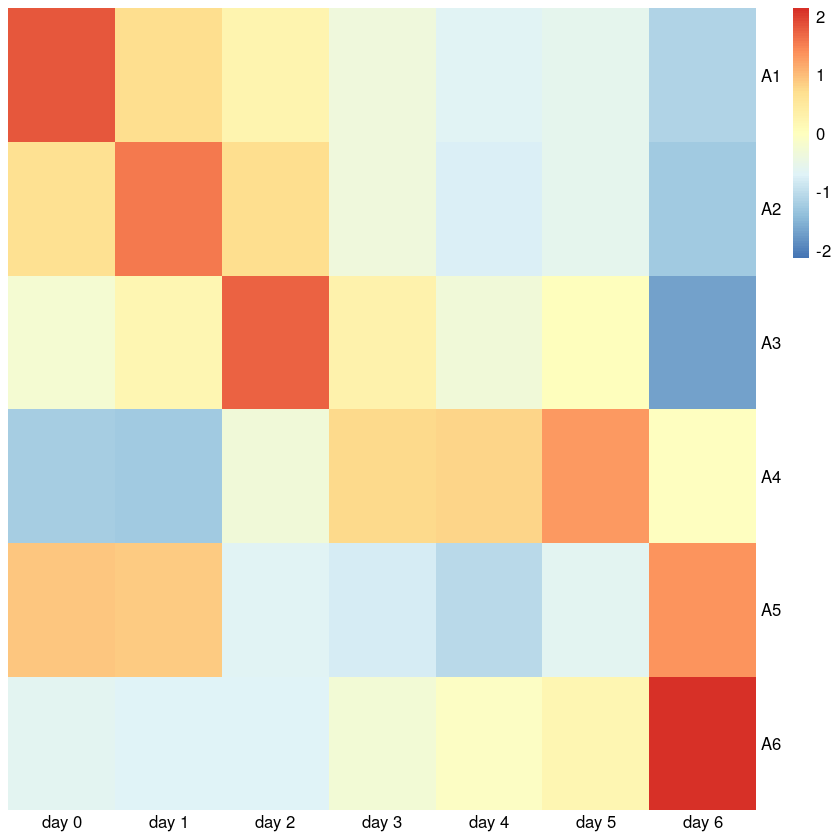

In [9]:
de_means <- aggregate(de_cluster[, paste0("day ", seq(0, 6))], list(de_cluster$cluster), mean)
rownames(de_means) <- de_means$Group.1

pheatmap(de_means[, -1], scale = "row", cluster_cols = F, cluster_rows = F, fontsize = 10,
         angle_col = 0, show_colnames = T, border_color = NA)

### Foregut Endoderm and day 6 - Spline Fit using time point of sampling

In [10]:
## Select cells from first and second stage (day 0 - 10) 
cells = rownames(meta[meta$day %in% seq(0, 10), ])
meta_spline = meta[cells, ]
data_spline = data[, cells]
print(dim(data_spline))

## Spline Fit and hierarchical clustering based on average expression per day for resulting significant genes
res_fe <- fit_splines(data_spline, meta_spline, kn = c(3, 6, 8))
fe_genes <- rownames(res_fe[res_fe$adj.P.Val < 0.005,])   # 9352 genes
fe_cluster = cluster_temporal_genes(scaled_data[fe_genes, cells], meta_spline)

## Manually re-annotate and combine to final 6 cluster
## (8, 3) <- B_1     (5, 1) <- B_2        6 <- B_3     9 <- B_4      (4, 2, 10) <- B_5    7 <- B_6
cluster_map <- c("B2", "B5", "B1", "B5", "B2", "B3", "B6", "B1", "B4", "B5")
names(cluster_map) <- seq(1, 10)

fe_cluster$adj.pval <- res_fe$adj.P.Val[match(rownames(fe_cluster), rownames(res_fe))]
fe_cluster$cluster <- cluster_map[fe_cluster$cluster.k10]

head(fe_cluster)

[1] 26936  7822


gene,day 6,day 7,day 8,day 9,day 10,cluster.k10,cluster.k20,adj.pval,cluster
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
BNIP3,0.9027394,-0.1855257,-0.2929606,-0.3950543,-0.3310495,3,3,0,B1
CCKBR,0.6253275,0.1836982,-0.2480503,-0.5401819,-0.5837009,3,3,0,B1
CER1,1.7444158,-0.4524991,-0.5816189,-0.5836073,-0.5820584,3,3,0,B1
CNTNAP2,0.4089205,0.3103166,-0.3196186,-0.3716952,-0.4322275,3,3,0,B1
CXCR4,1.3646068,-0.3868236,-0.4478652,-0.4205115,-0.4346388,3,3,0,B1
CYP26A1,1.0258340,-0.1244922,-0.4214052,-0.4145672,-0.4079360,3,3,0,B1


### Figure 3 g - Mean expression per time point based on clustering of significant time associated genes (FE)

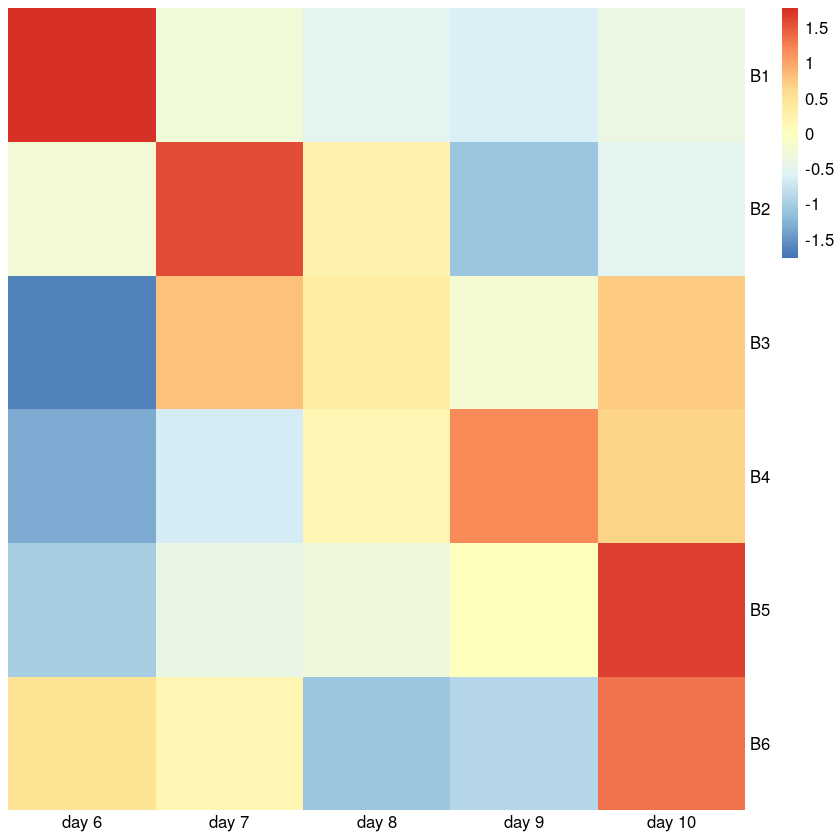

In [11]:
fe_means <- aggregate(fe_cluster[, paste0("day ", seq(6, 10))], list(fe_cluster$cluster), mean)
rownames(fe_means) <- fe_means$Group.1

pheatmap(fe_means[, -1], scale = "row", cluster_cols = F, cluster_rows = F, fontsize = 10,
         angle_col = 0, show_colnames = T, border_color = NA)

### Line Plots of average expression trends per cluster with specific genes highlighted

In [12]:
plot_cluster_kinetics_highlight <- function(means, clust, highlight, days = seq(0, 15)){
  curr <- means[means$cluster == clust, c(paste0("day ", days), "gene", "cluster")]
  high <- curr[curr$gene %in% highlight,]
  high <-  melt(high, c("gene", "cluster"))
  high$variable <- as.numeric(gsub("day ", "", high$variable))
  
  ## If there are more than 100 genes in cluster, only plot first 100
  if(dim(curr)[1] > 100){
    curr <- curr[1:100,]
  }
  curr <- melt(curr, c("gene", "cluster"))
  curr$variable <- as.numeric(gsub("day ", "", curr$variable))
  curr <- curr[curr$variable %in% days,]
  
  p <- ggplot(data = curr, aes(x = variable, y = value)) + geom_line(aes(group = gene), colour = "lightgray") +
    geom_line(aes(x = variable, y = value, color = gene), size = .8, alpha = 0.7, data = high) +
    geom_smooth(se = T, size = 1.5, method = 'loess', formula = "y ~ x") + 
    theme(panel.background = element_blank(), axis.line = element_line(colour = "black"),
          plot.title = element_text(hjust = 0.5),
          axis.text = element_text(size = 15), axis.title = element_text(size = 15,)) +
    labs(y = "mean expression (scaled)", x = "days", title = paste("Cluster", clust))
  
  return(p)
}

### Figure 3 c - average expression lineplot (Definite Endoderm)

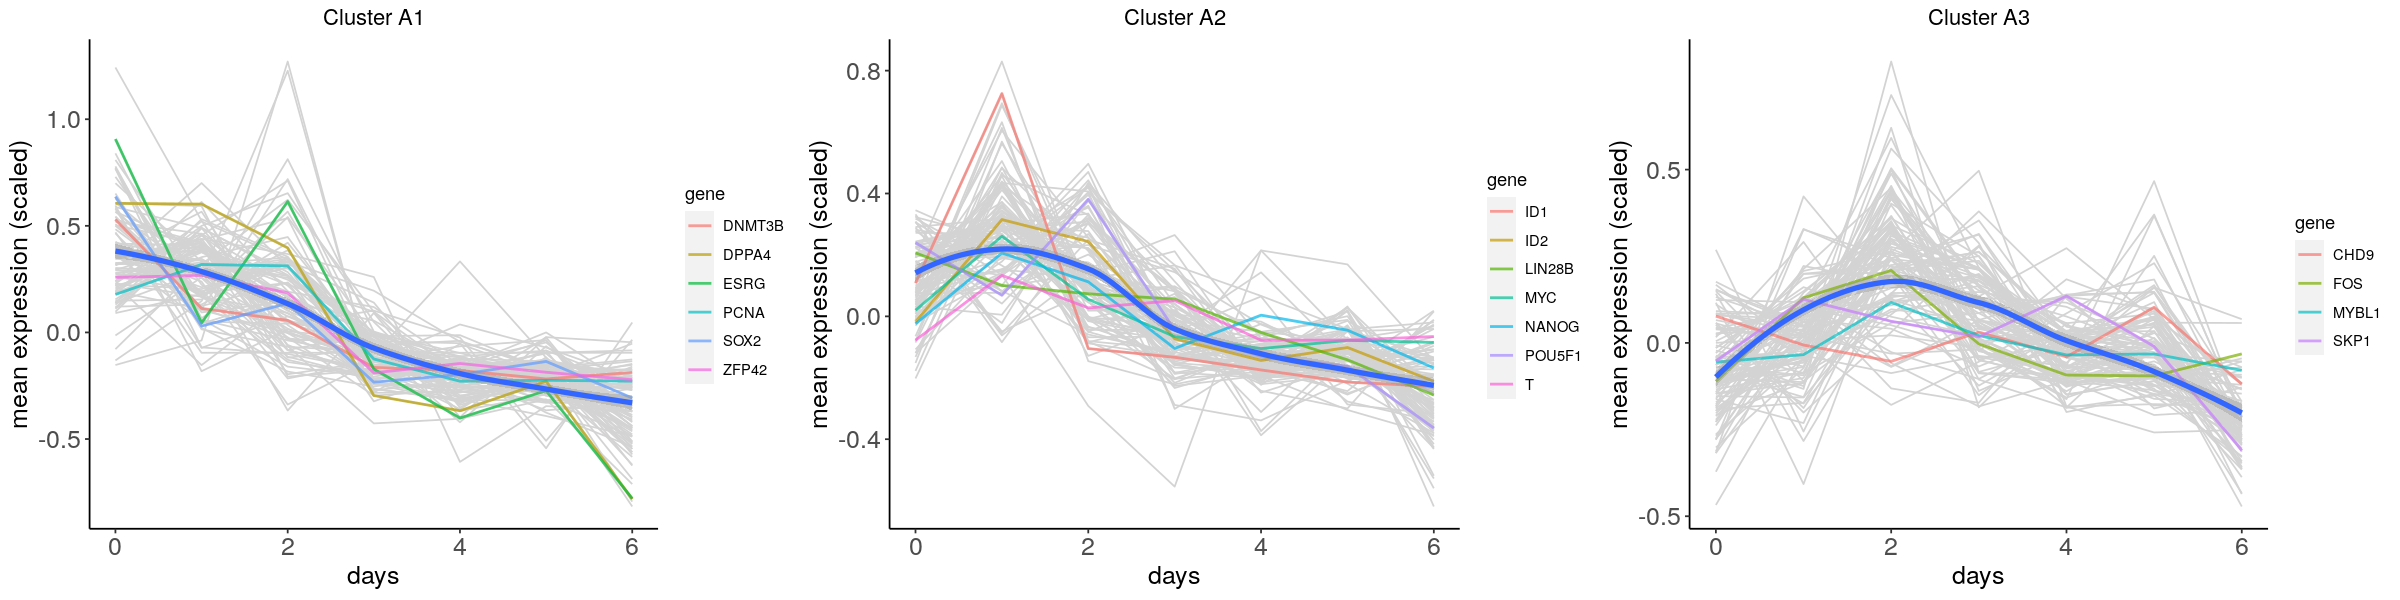

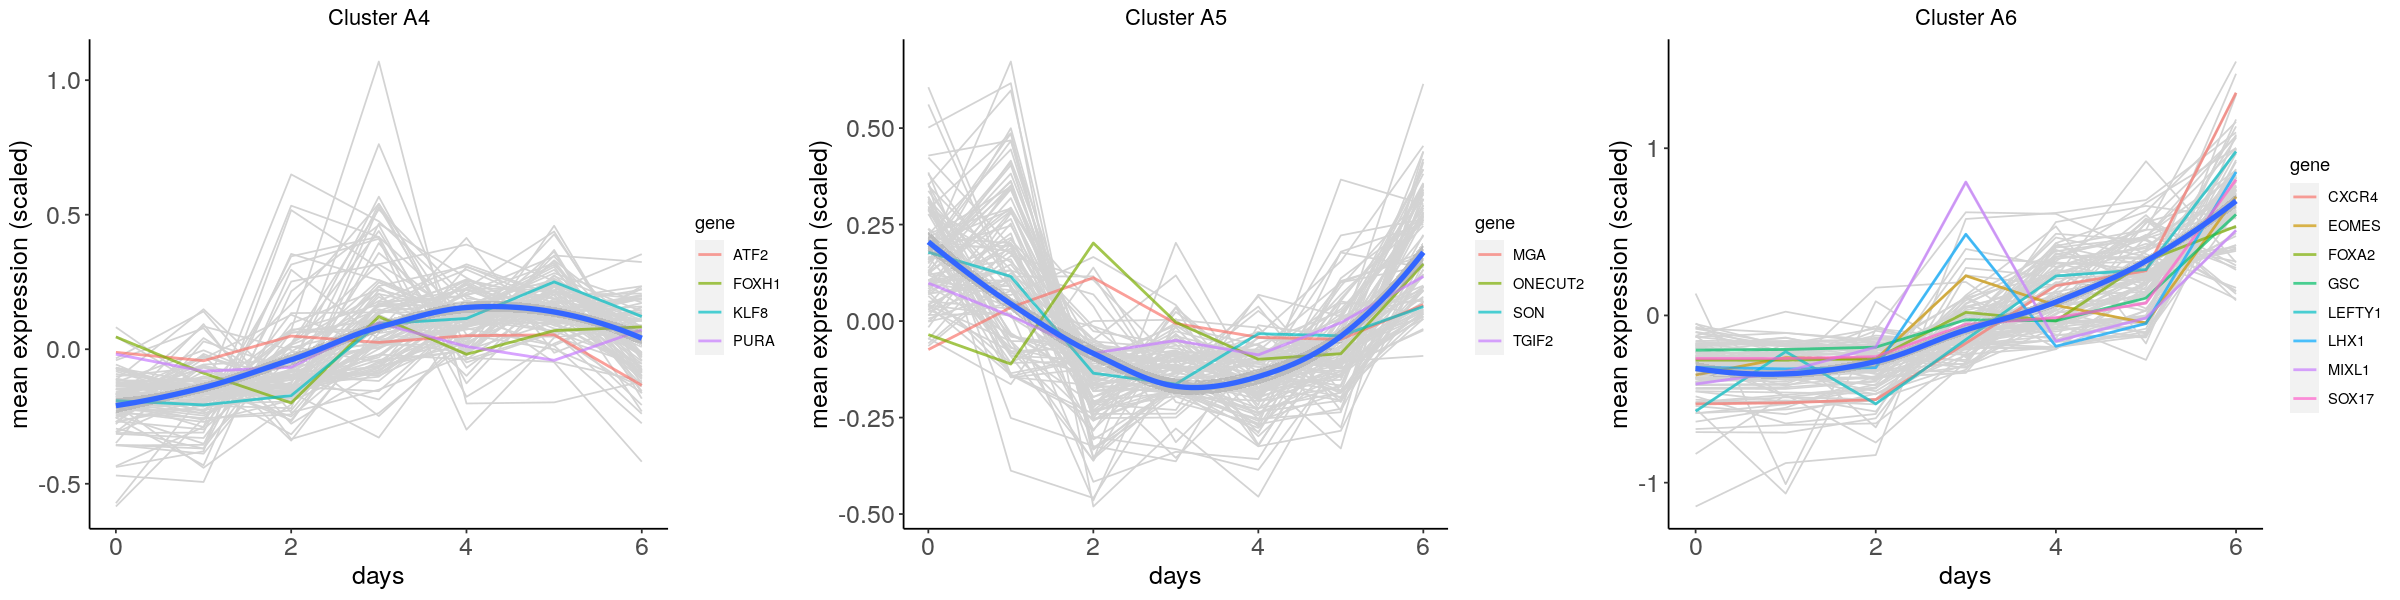

In [14]:
options(repr.plot.width = 20, repr.plot.height = 5, repr.plot.res = 120)

de.highlight <- c("DPPA4", "ESRG", "SOX2", "DNMT3B", "PCNA", "ZFP42", "ID1", "POU5F1", "ID2", "LIN28B", "LHX1",
                  "MYC", "NANOG", "T", "CHD9", "SKP1", "FOS", "MYBL1", "FOXH1", "KLF8", "PURA", "ATF2", "SOX17",
                  "ONECUT2", "SON", "TGIF2", "MGA", "CXCR4", "EOMES", "FOXA2", "GSC", "LEFTY1", "MIXL1")

a1 <- plot_cluster_kinetics_highlight(de_cluster, clust = "A1", highlight = de.highlight, days = seq(0, 6))
a2 <- plot_cluster_kinetics_highlight(de_cluster, clust = "A2", highlight = de.highlight, days = seq(0, 6))
a3 <- plot_cluster_kinetics_highlight(de_cluster, clust = "A3", highlight = de.highlight, days = seq(0, 6))

a4 <- plot_cluster_kinetics_highlight(de_cluster, clust = "A4", highlight = de.highlight, days = seq(0, 6))
a5 <- plot_cluster_kinetics_highlight(de_cluster, clust = "A5", highlight = de.highlight, days = seq(0, 6))
a6 <- plot_cluster_kinetics_highlight(de_cluster, clust = "A6", highlight = de.highlight, days = seq(0, 6))

grid.arrange(a1, a2, a3, ncol = 3)
grid.arrange(a4, a5, a6, ncol = 3)

### Figure 3 g - average expression lineplot (Foregut Endoderm and day 6)

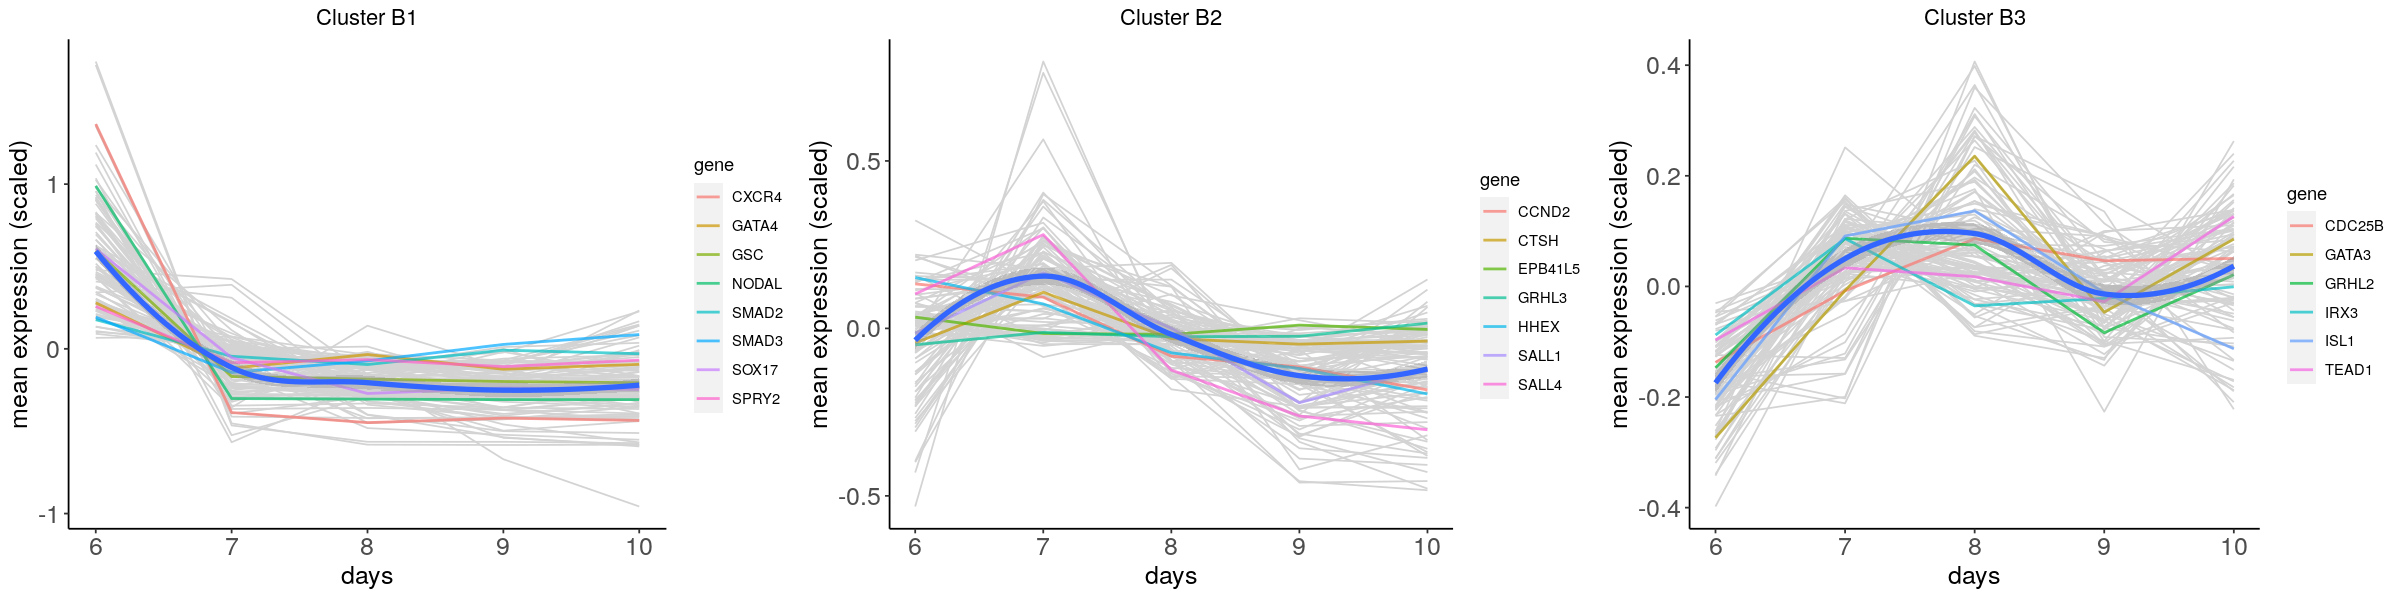

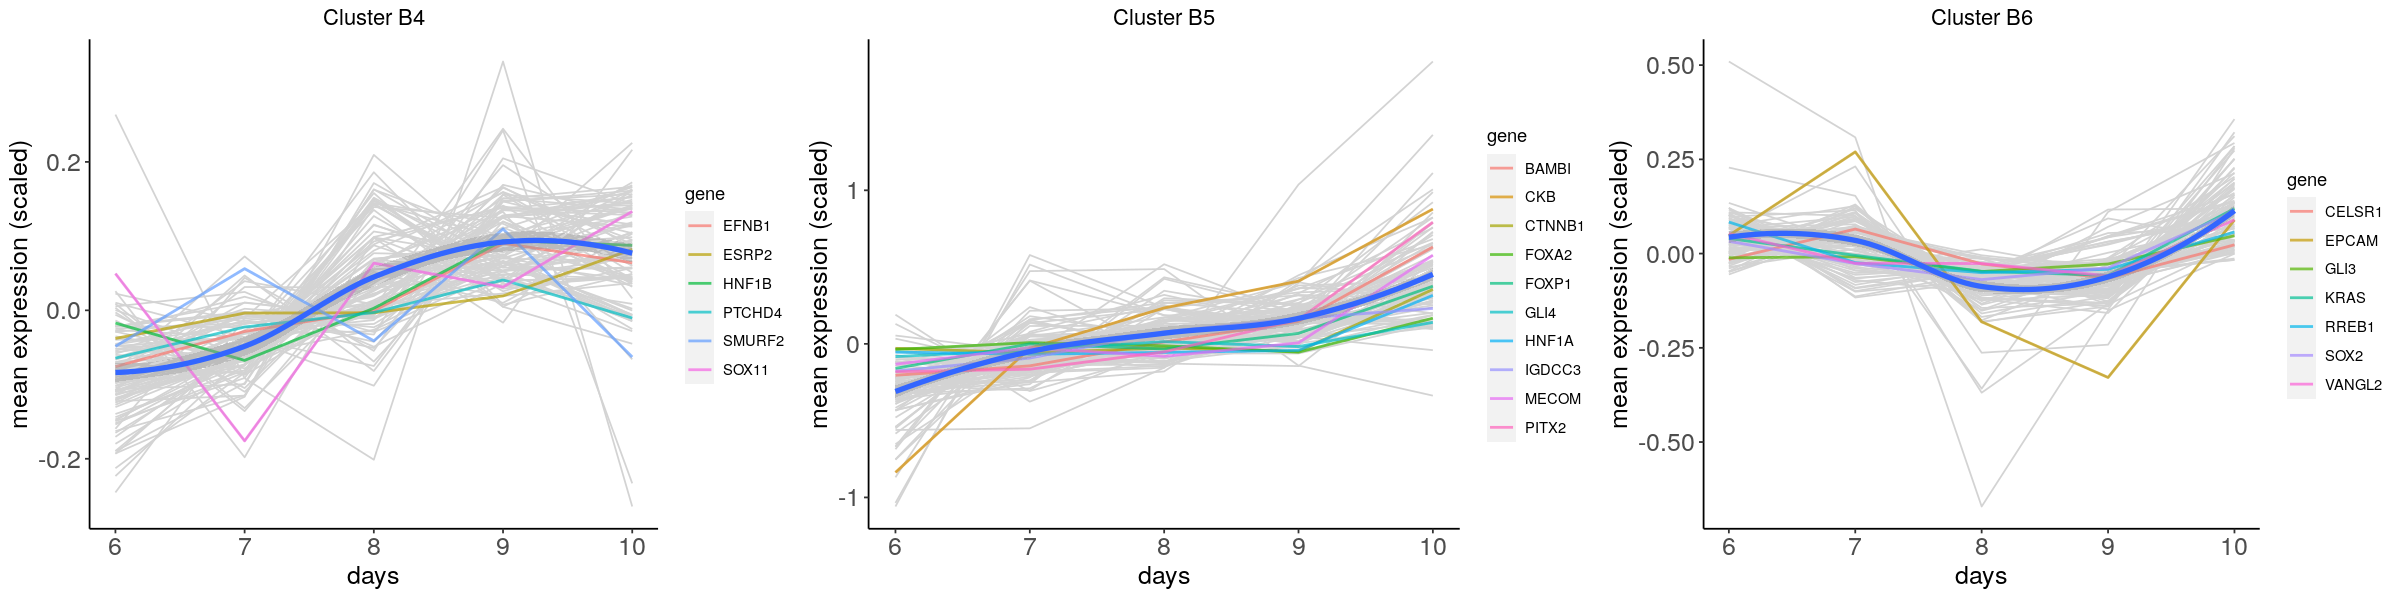

In [15]:
options(repr.plot.width = 20, repr.plot.height = 5, repr.plot.res = 120)

fe.highlight <- c("CXCR4", "SOX17", "NODAL", "GSC", "GATA4", "SPRY2", "SMAD3", "SMAD2", "SALL1", "HHEX", 
                  "CCND2", "SALL4", "GRHL3", "CTSH", "EPB41L5", "ISL1", "TEAD1", "IRX3", "GRHL2", "GATA3",
                  "CDC25B", "HNF1B", "SOX11", "PTCHD4", "ESRP2", "EFNB1", "SMURF2", "IGDCC3", "MECOM", 
                  "FOXA2", "FOXP1", "PITX2", "BAMBI", "CKB", "CTNNB1", "HNF1A", "GLI4", "GLI3", "SOX2", 
                  "EPCAM", "CELSR1", "VANGL2", "KRAS", "RREB1")

b1 <- plot_cluster_kinetics_highlight(fe_cluster, clust = "B1", highlight = fe.highlight, days = seq(6, 10))
b2 <- plot_cluster_kinetics_highlight(fe_cluster, clust = "B2", highlight = fe.highlight, days = seq(6, 10))
b3 <- plot_cluster_kinetics_highlight(fe_cluster, clust = "B3", highlight = fe.highlight, days = seq(6, 10))

b4 <- plot_cluster_kinetics_highlight(fe_cluster, clust = "B4", highlight = fe.highlight, days = seq(6, 10))
b5 <- plot_cluster_kinetics_highlight(fe_cluster, clust = "B5", highlight = fe.highlight, days = seq(6, 10))
b6 <- plot_cluster_kinetics_highlight(fe_cluster, clust = "B6", highlight = fe.highlight, days = seq(6, 10))

grid.arrange(b1, b2, b3, ncol = 3)
grid.arrange(b4, b5, b6, ncol = 3)